Pysam is a python libary that can be used to explore sam files

In [33]:
import pysam
from collections import defaultdict
import matplotlib.pyplot as plt

fname = "../map.sam"
for aln in pysam.AlignmentFile(fname, "r"):
    print(aln.query_name)
    print(aln.reference_name)
    print(aln.reference_start)
    print(aln.reference_end)
    print(aln.query_sequence)
    print(aln.query_qualities)
    print(aln.mapping_quality)
    print(aln.cigarstring)
    print(aln.cigartuples)
    print(aln.reference_start)
    print(aln.reference_end)
    break

a6b08eb2-38bc-4ee8-bd44-f9ef896b4f76
MZ501093.1
49418
50334
TAGATCCCGGGTAGATATCAAACTGCGCCAGGTAGGCTGCCTTCTGAACACCACCAGTATAAAACACACCAACATTGAGCTCCTTGCGCCAATACTCGATGTCTACATTGTCTTGAGTAATGAATCGGAAAGTCACAAGGTAGACTGTCCACCCCTCTTTATATTCCTGATCAGGCGGGAGAAGATGAAAGGGCTCGCATTAAACGTTCCATCAAAGTCAATGGCGATGATGTGCGTGCCGTGGCGAGTTCTCGATATGGATTGCTCGTGGTAAGATCGCTGTAGTTAAAAGGAACTTCTTCCCCGCAGTAGCTGTAGTCCATATTCACACCTTCTCGTTGATAAATTTACGGGCGGTTTGGTGAGTTGTTTCTGCTGTCTTCAGAATGATATTAATTTTATTGTCAAGATCATTCATCTCTGCAGTTAATTCAGGAATCTCTCCGGCATGCATGGTAAAATCATACATAGACATGCCCAGAATCTCATTGATGCGGCGGTTGCATTCTGCAGCACGCTGGTTCATTTTCCAAGCTAACACCAAAGCCTCCTGCGTAGCCTCTAGTGCAAAATCTAATACGTCGGCCTCTTCTTTCGTCATTCCACTTTCTCCGTTGTATTGTTGTTGGTAGGTGCATGAATACCTTATAACTCACCTTTTATTCAAACTGTAATAGCAAGTCCACTACCGCGCTAGGTCTGTCAACAAATTCCCCAGGCCCACATGCCCACAGAGGGTATCCGTCTACATACCGCCAAATCGCGACCTGCGGTGTGGAGTTCGAGCAGGGCAGTGCCGTCCTTACTGTCAACCACTCTTTCCCACAGTGTCGGGCAGCGAAGCTTGAGGACCGGATCACCTCCCTTATACCCGTCCATGTAGATACCCATTGCAAAGTTCAGCATCATCTTTTTGTGCACTTGAT
array('B', [6

let's count the number of forward/reverse mappings, and the number of primary / secondary / supplementary / unmapped alignments

In [65]:
aln_direction = defaultdict(int)
aln_type = defaultdict(int)
unmapped_seqs = []
for aln in pysam.AlignmentFile(fname, "r"):
    dr = "forward" if aln.is_forward else "reverse"
    aln_direction[dr] += 1

    tp = "primary"
    if aln.is_secondary:
        tp = "secondary"
    if aln.is_supplementary:
        tp = "supplementary"
    if aln.is_unmapped:
        tp = "unmapped"
        unmapped_seqs.append(aln.query_sequence)
    aln_type[tp] += 1

print(dict(aln_direction))
print(dict(aln_type))

{'reverse': 3909, 'forward': 3900}
{'primary': 7538, 'supplementary': 237, 'unmapped': 34}


What do unmapped sequences contain?

In [52]:
print(max(unmapped_seqs, key=len))

TTTTTATGTACATCTACTCGTTCGTATGCAGCCAGTATAAACGTTCCTCGTGCAGTGTCAGAGATGTTTTCGCATTTATCGTGCAACGCTTCGCGTTTTTCGTGCGGCCGCTTCATCTATGAATGGCCGCCCAGAACCAGCAGTGCGCTGGATACGCTGCTTCGTGAAATTCAGAACGCACGCGAACAACACAGCCGTCTTGATACGCTGATCCGCTCTTATGCCGCCCAGGACATGAAAACCGGCCTCAATAACCGACTCTTCTTCGATAATCAGTTAGCAACGTTACTGGAAGATCAGGAGAAAGTAGGTACCCACGGGATCGTGATGATGATTCGTCTGCCGGATTTCATATGTTGAGTGATACCTGGGGGCACAGCCAGGTTGAAGAACAGTTCTTCTCTCTGACGAATCTGCTATCGACATTTATGATGCGCTACCCTGGCGCACTGCTGGCGCGTTACCACCGCAGTGATTTTGCTGCGCTGTTACCGCACCGGACGTTAAAAGAGGCAGAGAGCATCGCCGGTCAGTTAATCAAAGCCGTCGATACCTTGCCGAACAATAAAATGCTCGATCGCGACGATATGATCCACATTGGTATCTGCGCCTGGCGTAGTGGTCAGGATACCGAGCAGGTAATGGAACATGCAGAGTCTGCCACGCGTAATGCGGGATTGCAGGGCGGCAATAGCTGGGCTATTTACGATGACTCGTTCCTAAAAAGGACGCGGTAATGTTCGCTGGCGTACGCTTATCGAGCAAATGCTGAGTCGCGGCGGCCCGCGCCTTTATCAAAAACCGGCGGTTACTCGCGAAGGTCAGGTTCATTCATCGCGAACTCATGTGCCGCATCTTCGATGGTAATGAAGAGGTTAGCTCGGCGGAGTATATGCCGATGGTCTTGCAGTTTGGCTTATCGGAAGAGTATGACCGCCTGCAAATCAGCCGTCTTATTCCACTATTGCGTTACTGGCCTGAGGAAAATCTGGCGATTCAG

What is the length and number of in/dels in the alignment?

In [60]:
I_len = defaultdict(int)
D_len = defaultdict(int)
M_len = defaultdict(int)

for aln in pysam.AlignmentFile(fname, "r"):
    if aln.is_unmapped:
        continue
    for op, l in aln.cigartuples:
        if op == 0:
            M_len[l] += 1
        if op == 1:
            I_len[l] += 1
        if op == 2:
            D_len[l] += 1

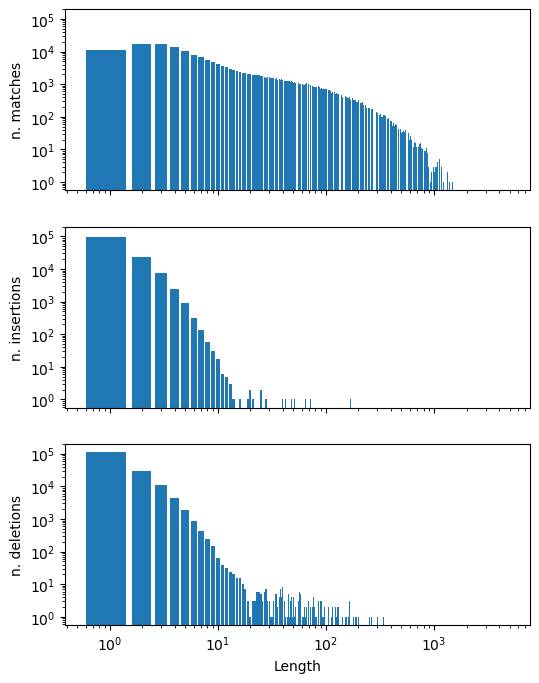

In [67]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)
axs[0].bar(M_len.keys(), M_len.values(), label="M")
axs[0].set_ylabel("n. matches")
axs[1].bar(I_len.keys(), I_len.values(), label="I")
axs[1].set_ylabel("n. insertions")
axs[2].bar(D_len.keys(), D_len.values(), label="D")
axs[2].set_ylabel("n. deletions")
plt.xlabel("Length")
plt.xscale("log")
plt.yscale("log")
plt.show()

For each aligned nucleotide we can get a quality score, and check whether it matches the expected nucleotide on the reference.

We can then check if the fraction of mismatches per different quality scores matches the expected error rate.

In [110]:
from Bio import SeqIO
import numpy as np

# load reference
ref_fname = "../bas54.fa"
with open(ref_fname, "r") as f:
    ref = SeqIO.read(f, "fasta").seq

# count mismatches and total number of bases per quality score
N_tot = defaultdict(int)
N_mismatches = defaultdict(int)

for aln in pysam.AlignmentFile(fname, "r"):
    if aln.is_unmapped:
        continue
    for q_pos, r_pos in aln.get_aligned_pairs():
        if (r_pos is None) or (q_pos is None):
            continue
        Q = aln.query_sequence[q_pos]
        R = ref[r_pos]

        q = aln.query_qualities[q_pos]
        if Q != R:
            N_mismatches[q] += 1
        N_tot[q] += 1

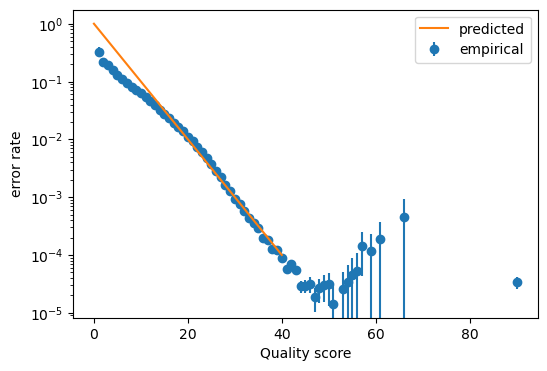

In [111]:
# calculate the empirical error rate
Qs = sorted(N_tot.keys())
mean = [N_mismatches[q] / N_tot[q] for q in Qs]
err = [np.sqrt(mean[i] * (1 - mean[i]) / (N_tot[q])) for i, q in enumerate(Qs)]

# and the predicted one based on q-score
q = np.arange(0, 41)
mean_est = np.pow(10, -q/10)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.errorbar(Qs, mean, yerr=err, fmt="o", label="empirical")
ax.plot(q, mean_est, label="predicted", zorder=3)
plt.xlabel("Quality score")
plt.ylabel("error rate")
plt.yscale("log")
plt.legend()
plt.show()